In [9]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torchvision.utils as tvutils

from my_utils.vis import *
from my_utils import models
from my_utils.utils import check_accuracy, load_model
from my_utils.data.dataset import MyDataset


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:3" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:3 now!


In [3]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 64)),
])

In [34]:
dataset = MyDataset(
    dataset_root='/mnt/cfs/wangyh/blender/blank_wall/raw_pngs/variety/',
    reduce_mode='H',
    transform=T,
    mat_name='N0',
    cls_mode='action'
)
loader = DataLoader(dataset, batch_size=64, shuffle=False)
len(loader.dataset)
# print(unseen_loader.dataset[0][0].shape)

Loading dataset:


100%|███████████████████████████████████████████| 1281/1281 [00:08<00:00, 154.32it/s]


1280

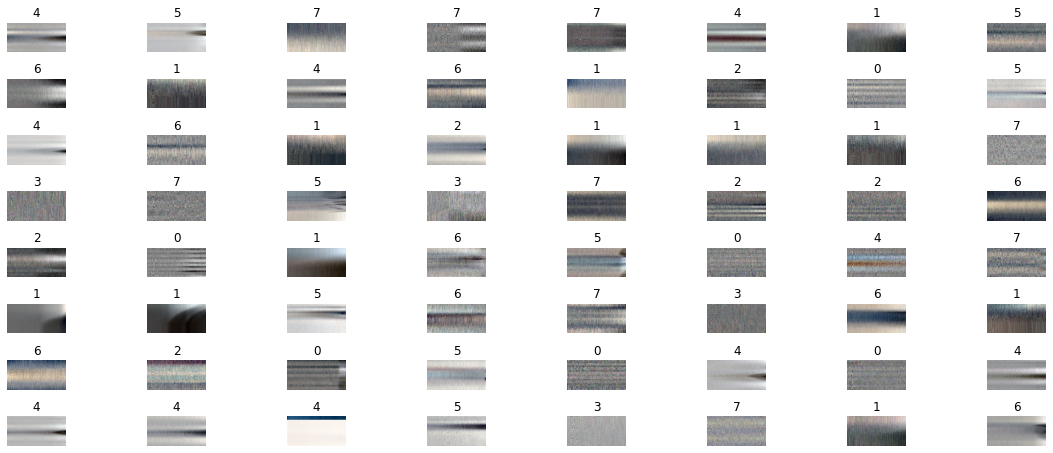

In [7]:
grid_vis(loader, row_num=8, multiply=5)

In [28]:
model = load_model(run_name='2022_06_01_11_49_42').to(device)

best val acc is: 0.88671875
Successfully load model parameters!


20it [00:05,  3.60it/s]


Test accuracy is : 93.98%	Infer time: 5.563704967498779


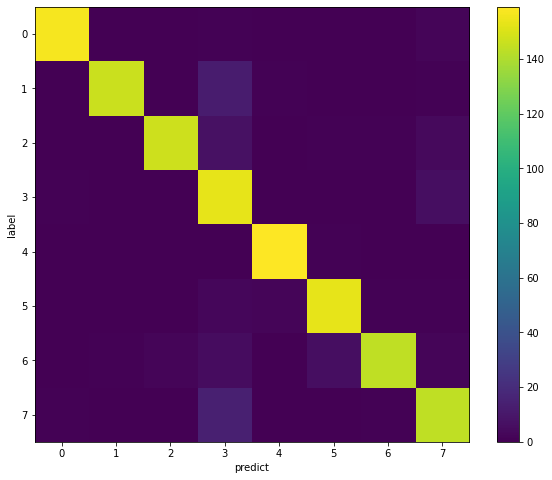

In [35]:
m = check_accuracy(model, loader)

plt.imshow(m, cmap='viridis')
plt.ylabel('label')
plt.xlabel('predict')
plt.colorbar()
plt.show()